In [1]:
# kd crossover，close < ema 8, ema 8 < ema 18, ema 18 < 38, take profit 4 atr, stop loss 3 atr
# 1651366861000
# ! conda install -c conda-forge ta --yes

In [2]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1d'

# start epoch till now
start_time = 1672556207000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
sl_atr = 0.1
tp_atr = 12
kd_dir = 'Any'

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [6]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

              Close_Time     Open    Close     High      Low       Volume
0    2023-01-03 07:59:59  1200.33  1214.00  1224.29  1193.00  252794.1400
1    2023-01-04 07:59:59  1213.99  1214.55  1219.89  1204.93  205519.4944
2    2023-01-05 07:59:59  1214.56  1256.90  1272.60  1212.71  457799.6648
3    2023-01-06 07:59:59  1256.91  1251.24  1259.95  1242.81  272805.3300
4    2023-01-07 07:59:59  1251.25  1269.14  1276.70  1236.00  342344.2023
..                   ...      ...      ...      ...      ...          ...
143  2023-05-26 07:59:59  1799.89  1805.60  1818.81  1761.41  350633.0089
144  2023-05-27 07:59:59  1805.61  1827.79  1838.20  1796.99  275690.6854
145  2023-05-28 07:59:59  1827.80  1829.89  1836.12  1812.18  138824.9406
146  2023-05-29 07:59:59  1829.89  1908.64  1918.65  1823.60  378392.4371
147  2023-05-30 07:59:59  1908.64  1898.41  1927.62  1893.00  168985.4442

[148 rows x 6 columns]


In [7]:
df = raw_df.copy()

In [8]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()       

# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [9]:
indicators(df, kd_dir)
print(df)

              Close_Time     Open    Close     High      Low       Volume  \
0    2023-01-03 07:59:59  1200.33  1214.00  1224.29  1193.00  252794.1400   
1    2023-01-04 07:59:59  1213.99  1214.55  1219.89  1204.93  205519.4944   
2    2023-01-05 07:59:59  1214.56  1256.90  1272.60  1212.71  457799.6648   
3    2023-01-06 07:59:59  1256.91  1251.24  1259.95  1242.81  272805.3300   
4    2023-01-07 07:59:59  1251.25  1269.14  1276.70  1236.00  342344.2023   
..                   ...      ...      ...      ...      ...          ...   
143  2023-05-26 07:59:59  1799.89  1805.60  1818.81  1761.41  350633.0089   
144  2023-05-27 07:59:59  1805.61  1827.79  1838.20  1796.99  275690.6854   
145  2023-05-28 07:59:59  1827.80  1829.89  1836.12  1812.18  138824.9406   
146  2023-05-29 07:59:59  1829.89  1908.64  1918.65  1823.60  378392.4371   
147  2023-05-30 07:59:59  1908.64  1898.41  1927.62  1893.00  168985.4442   

            bb_u         bb_m         bb_l        rsi     slow_k     slow_d

In [10]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'] >= df['bb_m']
        # c2
        df['c2'] = df['Close'] <= df['bb_u']
        # c3
        df['c3'] = (df['Close'] - df['Open'] < 0) & (df['Close'].shift(1) - df['Open'].shift(1) > 0)
        # c4
        df['c4'] = df['Volume'] > df['Volume'].shift(1)
        # c5
        df['c5'] = df['Close'] < df['Open'].shift(1)


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 & df.c5, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,bb_u,bb_m,bb_l,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,c5,signal,open_entry
0,2023-01-03 07:59:59,1200.33,1214.00,1224.29,1193.00,252794.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False
1,2023-01-04 07:59:59,1213.99,1214.55,1219.89,1204.93,205519.4944,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False
2,2023-01-05 07:59:59,1214.56,1256.90,1272.60,1212.71,457799.6648,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,False
3,2023-01-06 07:59:59,1256.91,1251.24,1259.95,1242.81,272805.3300,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False
4,2023-01-07 07:59:59,1251.25,1269.14,1276.70,1236.00,342344.2023,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2023-05-26 07:59:59,1799.89,1805.60,1818.81,1761.41,350633.0089,1937.378448,1846.472333,1755.566218,45.214312,49.509434,57.349066,False,False,True,False,False,True,False,False
144,2023-05-27 07:59:59,1805.61,1827.79,1838.20,1796.99,275690.6854,1936.044746,1845.198333,1754.351921,48.758081,59.753353,51.487596,True,False,True,False,False,False,False,False
145,2023-05-28 07:59:59,1827.80,1829.89,1836.12,1812.18,138824.9406,1930.432135,1842.572000,1754.711865,49.093677,61.643712,56.968833,False,False,True,False,False,False,False,False
146,2023-05-29 07:59:59,1829.89,1908.64,1918.65,1823.60,378392.4371,1932.538058,1843.162000,1753.785942,59.741577,93.633935,71.677000,False,True,True,False,True,False,False,False


In [12]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
high_val = entry_df['High']
open_val = entry_df['Open']


for index, row in entry_df.iterrows():
    
    tp_rsi = 32
    tp_slow_k = 20
    tp_slow_d = 20
    
    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = high_val.shift(1).at[index]
#         entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
#         take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position & (entry_df.at[index, 'Close'] >= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position & (entry_df.at[index, 'rsi'] <= tp_rsi) & (entry_df.at[index, 'slow_d'] <= tp_slow_d):
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan
#         take_profit = np.nan
        entry_df.at[index, 'take_profit'] = close_val.at[index]


entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


              Close_Time     Open    Close     High      Low       Volume  \
34   2023-02-06 07:59:59  1666.39  1629.02  1673.81  1609.30  413579.6748   
35   2023-02-07 07:59:59  1629.01  1614.29  1658.56  1605.01  384119.4197   
44   2023-02-16 07:59:59  1555.70  1674.92  1680.00  1542.55  581207.8586   
50   2023-02-22 07:59:59  1703.27  1659.76  1716.66  1636.30  520354.4688   
51   2023-02-23 07:59:59  1659.77  1643.14  1666.95  1595.07  528875.4809   
67   2023-03-11 07:59:59  1437.32  1426.44  1439.43  1368.39  960262.4509   
77   2023-03-21 07:59:59  1780.67  1732.78  1803.05  1722.00  682848.1248   
78   2023-03-22 07:59:59  1732.77  1801.23  1835.00  1717.01  742348.4999   
80   2023-03-24 07:59:59  1734.34  1813.79  1857.16  1729.35  732061.1030   
84   2023-03-28 07:59:59  1773.88  1715.22  1780.48  1686.13  570563.5023   
85   2023-03-29 07:59:59  1715.21  1772.99  1795.73  1701.13  536511.3973   
86   2023-03-30 07:59:59  1773.00  1793.07  1827.99  1772.48  536865.5972   

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)

for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[index, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Short':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

        
# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):
    # check if the current position is 'Stop' or 'Buy'
    if pos.loc[i, 'position'] in ['Stop', 'Buy']:
        
        # if it is, initialize a variable to store the aggregated amount
        total_amt = pos.loc[i, 'amt'] - np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Buy'
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Buy']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt -= trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()
    

# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Short':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Buy', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if position_amt_sum > max_profit:
            max_profit = position_amt_sum
            
        if position_amt_sum < max_loss:
            max_loss = position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass


# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade > 0:
        wins += 1
    elif trade < 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')



   Profit   Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0   21.84  6.72      233.32    -81.01          1       1629.02   13.41%   

  Win_Rate  
0   25.00%  

            Close_Time     Open    Close     High      Low position  entry_p  \
0  2023-02-07 07:59:59  1629.01  1614.29  1658.56  1605.01    Short  1629.02   
1  2023-02-16 07:59:59  1555.70  1674.92  1680.00  1542.55     Stop      NaN   
2  2023-02-23 07:59:59  1659.77  1643.14  1666.95  1595.07    Short  1659.76   
3  2023-03-11 07:59:59  1437.32  1426.44  1439.43  1368.39      Buy      NaN   
4  2023-03-22 07:59:59  1732.77  1801.23  1835.00  1717.01    Short  1732.78   
5  2023-03-24 07:59:59  1734.34  1813.79  1857.16  1729.35     Stop      NaN   
6  2023-03-29 07:59:59  1715.21  1772.99  1795.73  1701.13    Short  1715.22   
7  2023-03-30 07:59:59  1773.00  1793.07  1827.99  1772.48     Stop      NaN   

   stop_loss  take_profit  size   exit_p      amt  
0    1673.81          NaN   1.0      NaN  1629.02

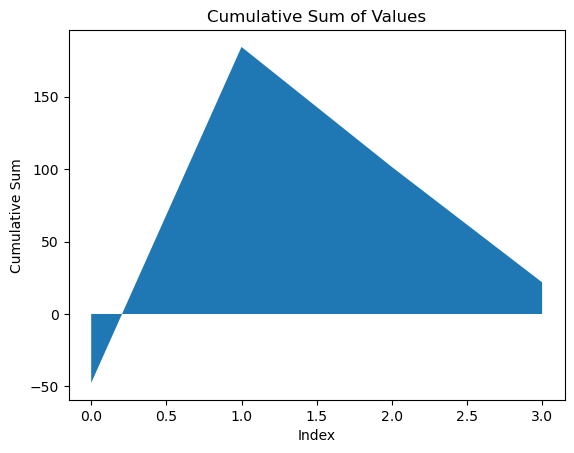

[-47.551970000000054, 184.2249299999998, 101.44164499999974, 21.83749999999975]


In [14]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

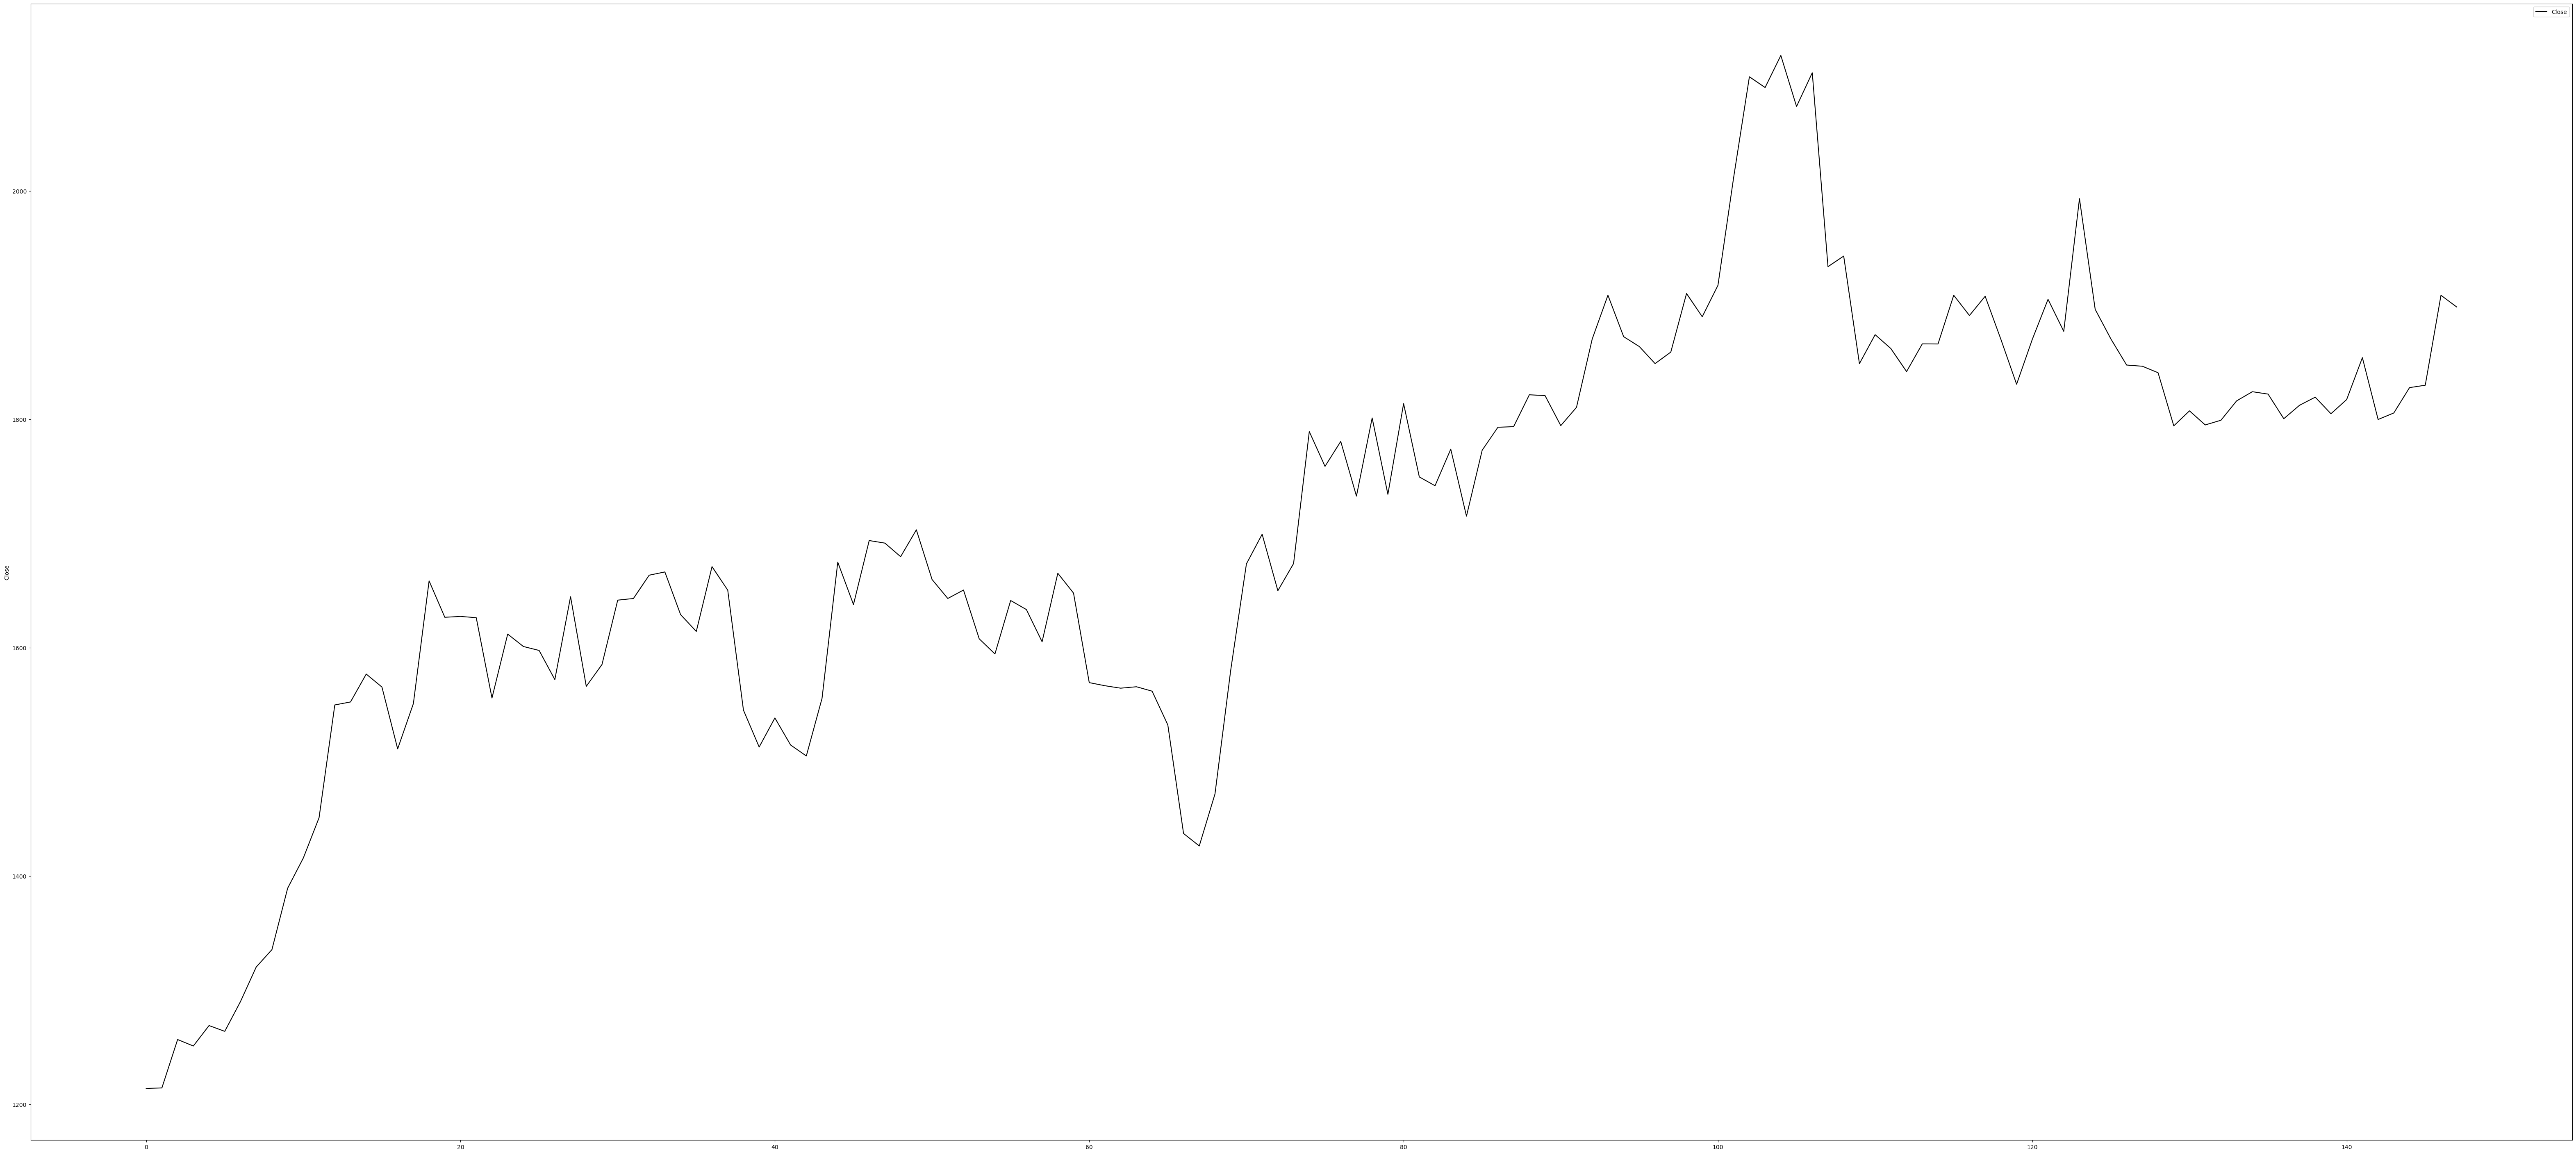

In [15]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()